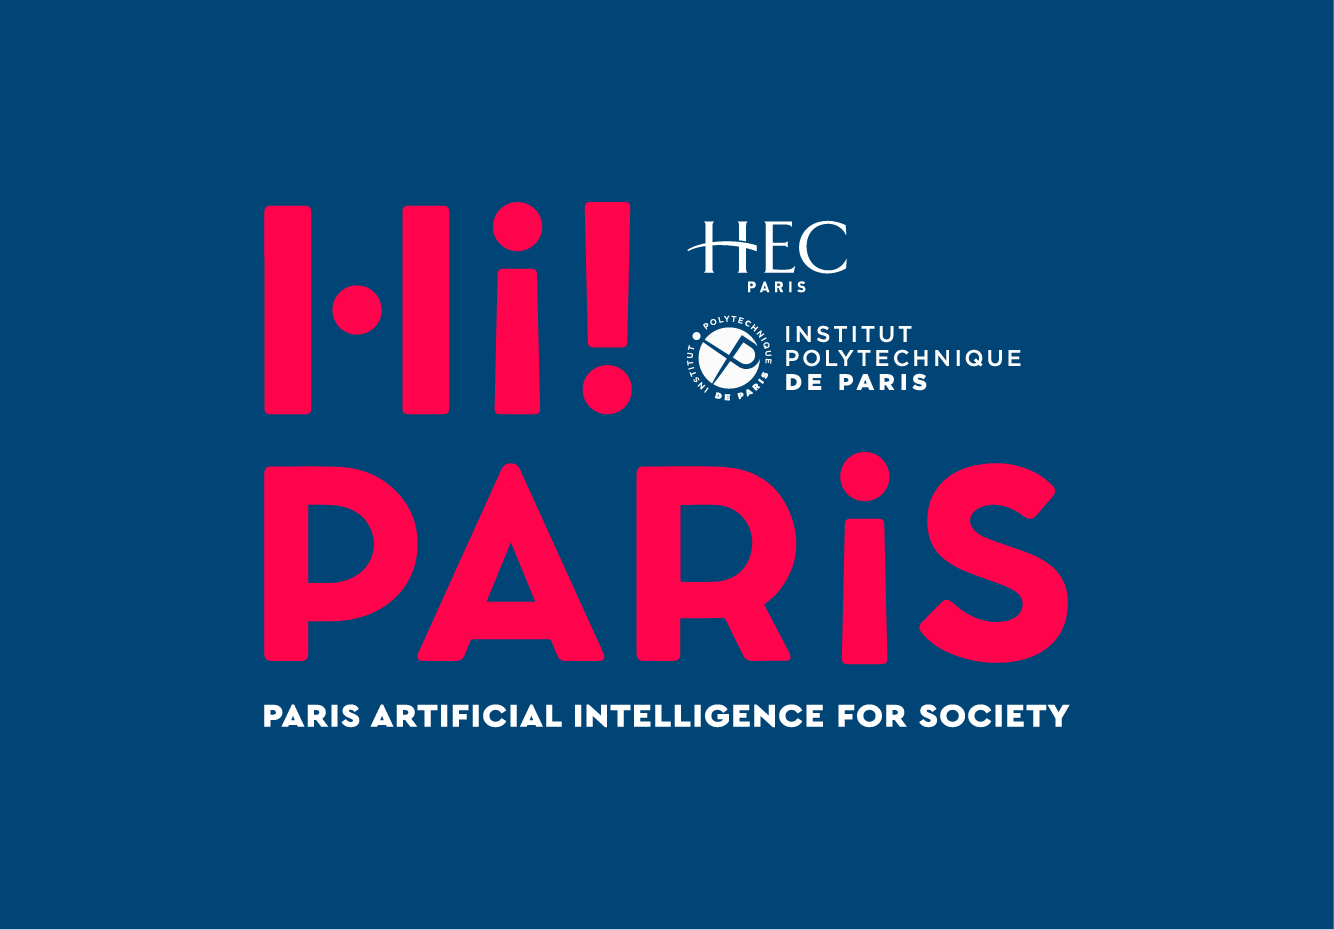

In [1]:
from IPython import display
display.Image("../src/figures/Hi!PARIS_logo_bleu.png")

<br>
<body>
    <p style="font-size:50px;text-align:center; color:#004475"><b><span style="color: #e61853">Hi!</span>ckathon 3</b></p><br>
    <p style="font-size:35px;text-align:center; color:#004475">Week 3 
    <p style="font-size:35px;text-align:center; color:#004475"> Preventing overfitting </p><br>
    <p style="font-size:25px;text-align:center; color:#004475">Estimated duration : 2h</p><br>
    <br><p style="font-size:15px;text-align:left; color:#004475"><b>Authors : Haddam Yacine, Ka Alioune, Renaud Adrien, Vizy Jean Nicolas and Calot Baptiste </b></p><br>
</body>
<br>

In this lab, we will introduce the bias/variance trade off, and some tools do deal with it.

# Data Path

`data_dir` is the path to data folder.

In [1]:
data_dir = "../data"

# Libraries 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, max_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn import tree

sys.path.append('../src/notebooks')

pd.set_option('display.max_columns', 500)

warnings.simplefilter(action='ignore', category=FutureWarning) 
warnings.simplefilter(action='ignore', category=UserWarning)

import time

# Load data 

In [4]:
train = pd.read_feather(os.path.join(data_dir, 'train.feather'))
val = pd.read_feather(os.path.join(data_dir, 'val.feather'))
test = pd.read_feather(os.path.join(data_dir, 'test.feather'))

In [5]:
features = [
    # 'building_id',
    'lat',
    'lng',
    'square_feet',
    'air_temperature',
    'dew_temperature',
    'precip_depth_1_hr',
    'wind_speed',
    'sea_level_pressure',
    'wind_direction',
    'hour',
    'weekday',
    'month',
    'meter_name_chilledwater',
    'meter_name_electricity',
    'meter_name_hotwater',
    'meter_name_steam',
    'primary_use_Education',
    'primary_use_Entertainment/public assembly',
    'primary_use_Healthcare',
    'primary_use_Industry',
    'primary_use_Lodging/residential',
    'primary_use_Office',
    'primary_use_Other',
    'primary_use_Parking',
    'primary_use_Public services',
    'primary_use_Services',
    'zone_geo_EUROPE',
    'zone_geo_US',
    'site_id_0',
    'site_id_1',
    'site_id_2',
    'site_id_3',
    'site_id_4',
    'site_id_5',
    'site_id_6',
    'site_id_7',
    'site_id_9',
    'site_id_11',
    'site_id_12',
    'site_id_13',
    'site_id_15',
]

target = "meter_reading"

In [7]:
train_features = train[features]
val_features = val[features]
test_features = test[features]

In [8]:
train_target = train[target]
val_target = val[target]
test_target = test[target]

In [9]:
scal = StandardScaler()
# We fit on the train
scal.fit(train_features) 
train_features = pd.DataFrame(scal.transform(train_features), columns= train_features.columns)
# We apply the transformation on the validation and test set
val_features = pd.DataFrame(scal.transform(val_features), columns = val_features.columns)
test_features = pd.DataFrame(scal.transform(test_features), columns = test_features.columns)

In [10]:
index_train_drop2= train_target[(train_target < 1) | (train_target >300)].index.tolist()
index_val_drop2 = val_target[(val_target < 1) | (val_target >300)].index.tolist()
index_test_drop2= test_target[(test_target < 1) | (test_target >300)].index.tolist()

train_target2 = train_target.drop(index_train_drop2)
train_features2 = train_features.drop(index_train_drop2)
val_target2 = val_target.drop(index_val_drop2)
val_features2 = val_features.drop(index_val_drop2)
test_target2 = test_target.drop(index_test_drop2)
test_features2 = test_features.drop(index_test_drop2)

train_features = train_features2
train_target = train_target2
val_features = val_features2
val_target = val_target2
test_features = test_features2
test_target = test_target2

To evaluate the perf of the models, we define the following function:

In [11]:
def print_errors(model, X, y):
    y_pred = model.predict(X)
    print(f'MAE : {mean_absolute_error(y, y_pred):.0f}')
    print(f'MSE : {mean_squared_error(y, y_pred):.0f}')

# The bias/variance trade-off

## Problem statement

The bias/variance trade-off is a common problem in machine learning, and must be handled carefully if you want to train models that are both performant and robust.

Let's say we want to predict labels $Y = (y_1, y_2, ..., y_n)$ using a function $ Y = \hat f(X) + \epsilon$ with $X = (X_1, X_2, ..., X_p)$, $\epsilon$ being an irreductible noise of the data of mean 0 and variance $\sigma ^2$

To evaluate model error, we can decompose the MSE as follows:

$MSE(\hat f(X))= Bias(\hat f(X), Y)^2 + Var(\hat f(X))  + \sigma ^2$

Where:

- $Bias(\hat f(X), Y) = E(\hat f(X)-Y)$ : The bias is the expected gap between predictions and true labels. Obviously, unbiased estimators (meaning estimators such that $E(\hat f(X)-Y)=0$) are often preferable over biased estimators.
- $Var(\hat f(X))=E((\hat f(X)-E(\hat f(X)))^2)$ measures the dispersion of the model's predictions.

This graphic illustrates what bias and variance are :

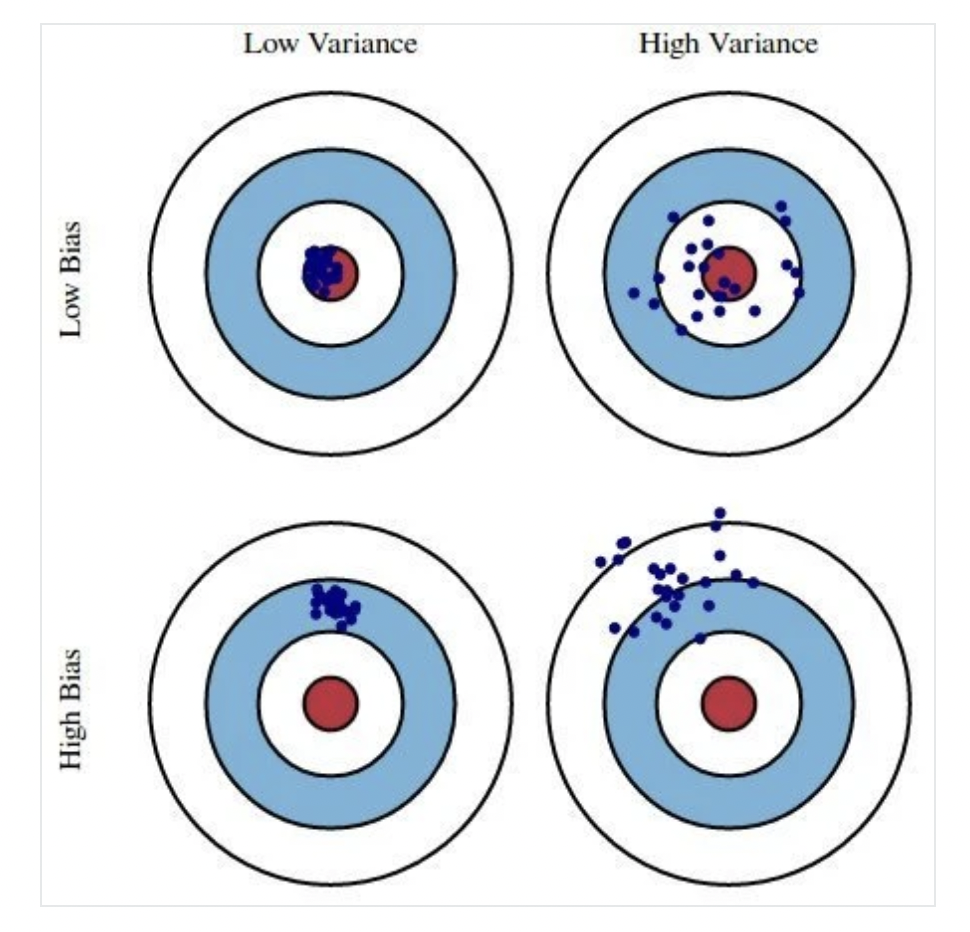

In [2]:
#<img src="../../src/figures/bias_variance.png" width=600 height=200 />
display.Image("../src/figures/bias_variance.png",height=800,width=600)

Both the bias and the variance are desired to be low, as large values result in poor predictions from the model. However, it can be difficult to minize both bias **and** variance: 
- In practice, high bias often occurs when model are too simple and fail to take each data point's specifities into account; this is referred to as **underfitting**.
- On the other hand, if the model complexity increases too much, the model gets too sensitive to small fluctuations in the data, yielding highly variable predictions and excessive variance. This is called **overfitting**.

Visually, the bias-variance tradeoff can be illustrated as follows, with undefitting occuring on the left-hand side, and overfitting on the right-hand side:

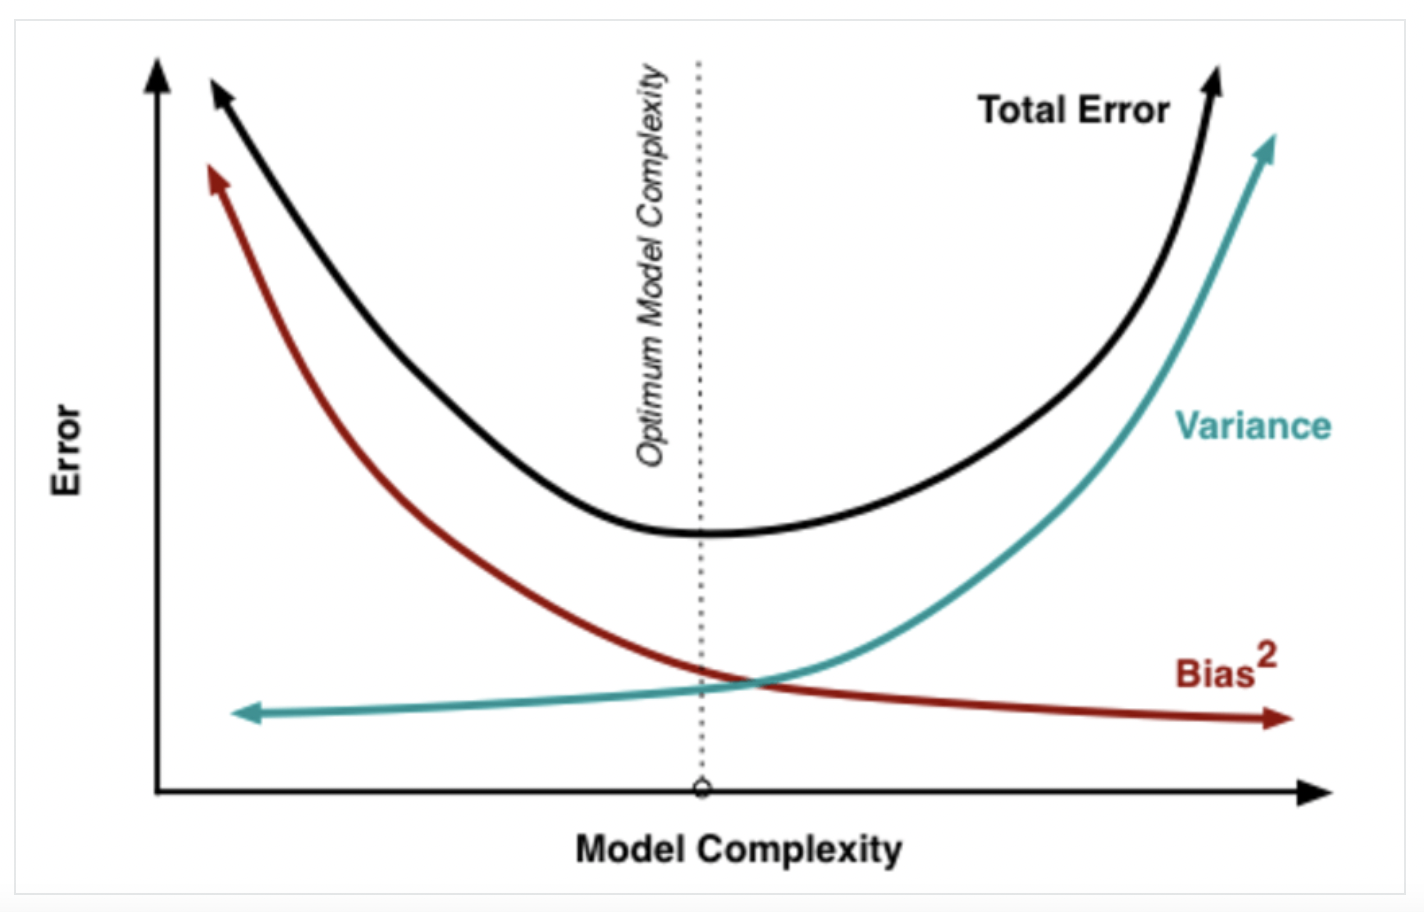

In [3]:
#<img src="../../src/figures/bias_variance_curve.png" width=600 height=200 />
display.Image("../src/figures/bias_variance_curve.png",height=800,width=600)

As a result, data scientists must find the optimal complexity for their models, by using some of the solutions below:

$\textbf{UNDERFITTING :}$ The model is too simple to capture the relationships between the data

*Solutions*:
- Introduce more features
- Increase model complexity


$\textbf{OVERFITTING :}$ The model is too complex, sticks too closely to the training data, and becomes overly sensitive to small deviations from the training data distribution.

*Solutions*:

- Decrease model complexity
- Remove unnecessary or noisy features
- Include more data
- **Use regularization**

## What is regularization?

While acting on the model complexity is an easy but simplistic solution, and adding more data is often not feasible, **regularization** is a good way to make a model more robust.

The general solution to preventing overfitting is to reduce variance at the cost of introducing some bias. 
It is often beneficial for the predictive performance of the model, and its ability to generalize well on new data, and avoid performance drift over time.

To be more precise, regularization consists in penalizing model complexity, to make sure it won't overfit. While it may take numerous forms and take place in all families of algorithms, let's focus on how it can be applied to linear models, with a few examples.

## Baseline - Standard linear regression

First, we will train a simple linear regression model on our data:

In [12]:
model_lm = LinearRegression()
model_lm = model_lm.fit(train_features, train_target)

Let's plot its regression coefficients:

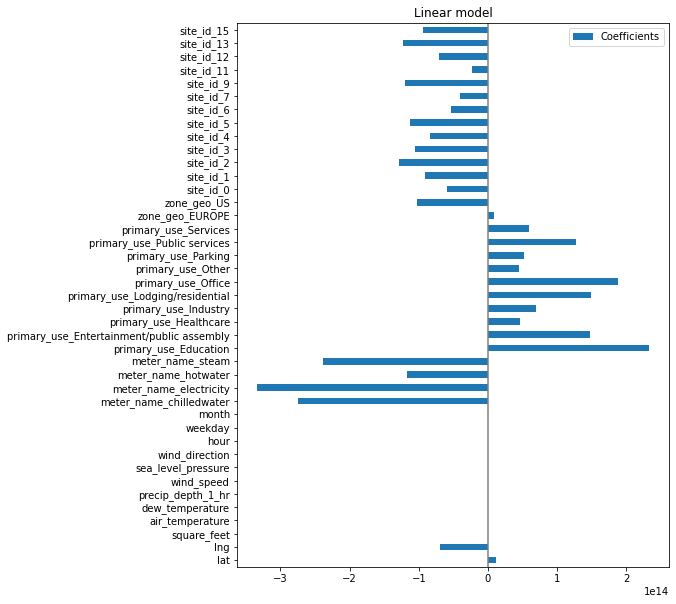

In [13]:
coefs = pd.DataFrame(
   model_lm.coef_,
   columns=['Coefficients'], index=train_features.columns
)

coefs.plot(kind='barh', figsize=(10, 10))
plt.title('Linear model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

As you can see, a lot of variables have huge regression coefficients. As a result, small variations on these features may impact predictions a lot, and thus cause significant variance. Let's compute this model's performance on the validation set for our records:

In [14]:
print_errors(model_lm, val_features, val_target)

MAE : 53
MSE : 4570


## L2-regularization (Ridge estimators):

In Ridge Regression we not only minimize the sum of squared residuals (as in ordinary least squares) but also penalize the magnitude of regression coefficients estimates, in order to shrink them towards zero and limitate variance. This can be summarized in the following equation:

We want to minimize

$ \underset{\beta}{min} [ \sum_{i=1}^n {(y_{i}-X_{i}\beta)^2} + \alpha||X||_2^2$ ]

Where $ \alpha $ $\in [0,+\inf]$ :

Setting $\alpha$ to 0 is the same as using the ordinary LSE, while with larger values, the model complexity will be more penalized. This, however comes at a cost: while the ordinary least squares models are unbiased, Ridge regressors have a positive bias.

From there you can see that as $\alpha$ becomes larger, the variance decreases, and the bias increases. This poses the question: how much bias are we willing to accept in order to decrease the variance? Or: what is the optimal value for $\alpha$?

In [15]:
model_ridge = Ridge(alpha = 100)
model_ridge = model_ridge.fit(train_features, train_target)

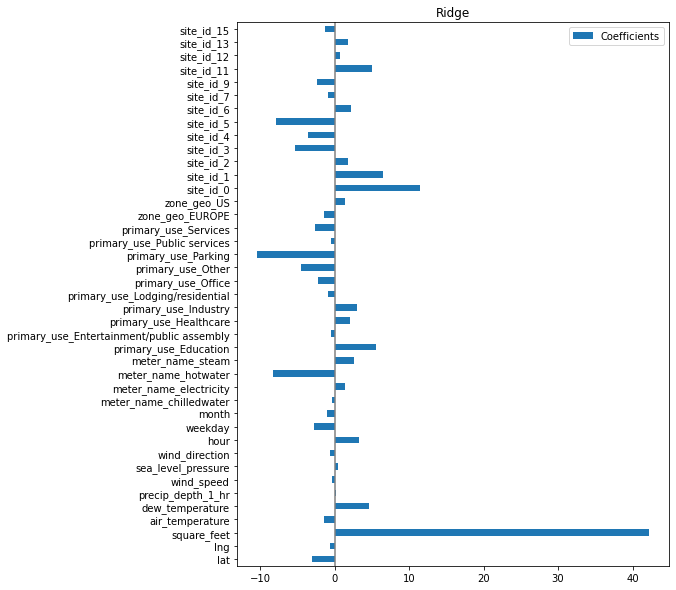

In [16]:
coefs = pd.DataFrame(
   model_ridge.coef_,
   columns=['Coefficients'], index=train_features.columns
)

coefs.plot(kind='barh', figsize=(10, 10))
plt.title('Ridge')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

The ridge model largely crushes the coefficients towards 0, compared to the previous model, which strongly decreases the sensitivity to noise. As a result, you can now see that the main predictor of energy consumption under this model is a building's area, which somewhat makes sense.

Let's now see how the model's performance evolves:

In [17]:
print_errors(model_ridge, val_features, val_target)

MAE : 53
MSE : 4570


At first sight, the metrics are quite similar to the previous model. However, the risk of having poor performance when generalizing on new data has decreased.

## L1-regularization (Lasso estimator):

Lasso, or **Least Absolute Shrinkage and Selection Operator**, is quite similar conceptually to ridge regression. It also adds a penalty for non-zero coefficients, but unlike ridge regression which penalizes sum of squared coefficients (the so-called L2 penalty), lasso penalizes the sum of their absolute values (L1 penalty). As a result, for high values of $\alpha$, many coefficients are exactly zero under lasso, which is never the case in ridge regression.

Let's choose an $ \alpha $ $\in [0,+\inf]$ :

We want to minimize

$ \underset{\beta}{min} [ \sum_{i=1}^n {(y_{i}-X_{i}\beta)^2} + \alpha||X||_1$ ]

In [18]:
model_lasso = Lasso(alpha=5)
model_lasso = model_lasso.fit(train_features, train_target)

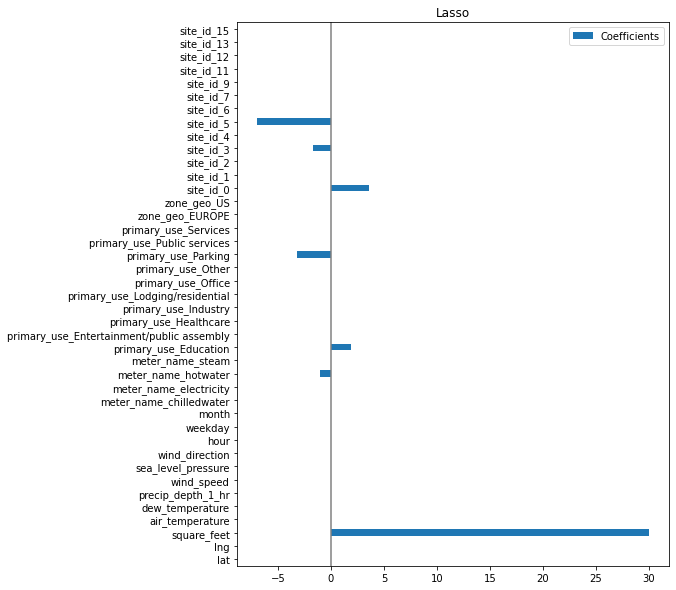

In [19]:
coefs = pd.DataFrame(
   model_lasso.coef_,
   columns=['Coefficients'], index=train_features.columns
)

coefs.plot(kind='barh', figsize=(10, 10))
plt.title('Lasso')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)


Here the result is a bit different. The coefficients are strongly crushed towards 0; many variables are not taken into account anymore. This may be interesting when you are trying to reduce the computational cost of a model or to improve prediction latency. 

In [20]:
print_errors(model_lasso, val_features, val_target)

MAE : 56
MSE : 4915


## Difference between Lasso and Ridge


Lasso can set some coefficients to zero, thus performing variable selection, while ridge regression cannot.

Both methods allow to use correlated predictors, but they solve multicollinearity issue differently:

- In ridge regression, the coefficients of correlated predictors are similar. Ridge works well if there are many large parameters of about the same value (when most predictors impact the response).

- In lasso, one of the correlated predictors has a larger coefficient, while the rest are (nearly) zero. Lasso tends to do well if there are a small number of significant parameters and the others are close to zero

- For Lasso, we want to minimize $ \underset{\beta}{min} [ \sum_{i=1}^n {(y_{i}-X_{i}\beta)^2} + \alpha||X||_1$ ].
- It can be written as : we want to minimize $\underset{\beta}{min} [ \sum_{i=1}^n {(y_{i}-X_{i}\beta)^2}]$ such that  $\exists s(\lambda) \in R_{+}$ with $||X||_1$ $\leq s$ 

- For Ridge, we want to minimize $ \underset{\beta}{min} [ \sum_{i=1}^n {(y_{i}-X_{i}\beta)^2} + \alpha||X||_2^2$ ].
- It can be written as : we want to minimize $\underset{\beta}{min} [ \sum_{i=1}^n {(y_{i}-X_{i}\beta)^2}]$ such that  $\exists s(\lambda) \in R_{+}$ with $||X||_2^2$ $\leq s$ 

This means that solution of the linear regression obtained by the method of least squares has to verify the constraint so the solution is a point located at the intersection of a level line of the error term $[ \sum_{i=1}^n {(y_{i}-X_{i}\beta)^2}]$ and the admissible region where the constraint is verified : 

- Since the error term $\sum_{i=1}^n {(y_{i}-X_{i}\beta)^2}$ is always quadratic in $\beta$ , the level line is an ellipsoid. 

- In the case of Lasso, the admissible region is a ball $l1$ of radius T , in other words, a hypercube. Since this ball has "corners", the ellipsoid is likely to meet it on one of these corners, where one or more coordinates are zero.


- In the case of Ridge, the admissible region is a ball $l2$ of radius T which is the round Euclidean ball which we are more used to.  There is no reason for this intersection to be at a point where one or more coordinates cancel out...


The geometrical interpretation to undestand why Lasso shrink coefficients to zero is as follow : 

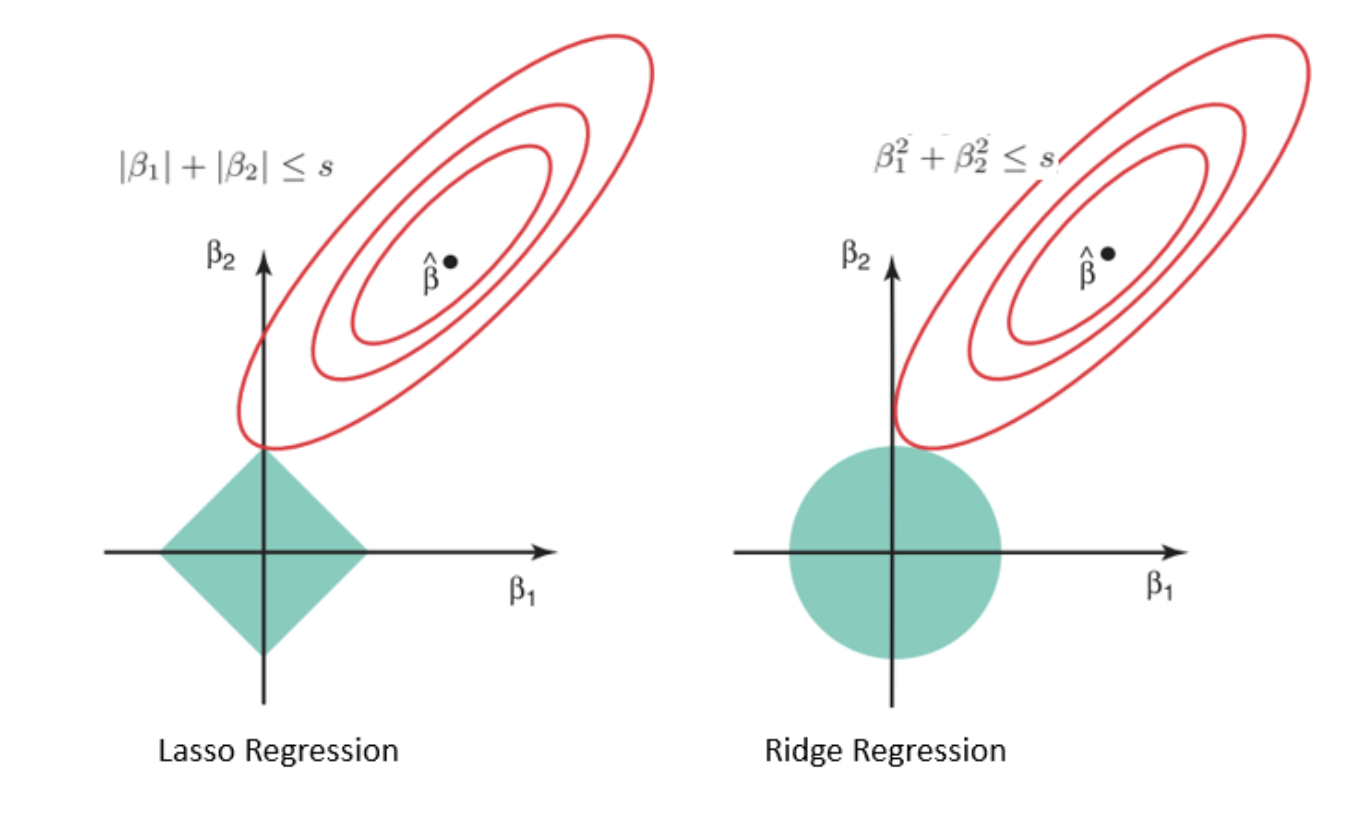

In [4]:
#<img src="../../src/figures/lasso_vs_ridge.png" width=700 height=400 />
display.Image("../src/figures/lasso_vs_ridge.png",height=00,width=700)

-Lasso is good when you have a few features with high predicting power while the others are useless: it will zero out the useless ones and keep only a subset of the variables.

-Ridge is good when the predicting power of your dataset is spread out over the different features: it will not zero out features that could be helpful when making predictions but will simply reduce the weight of most variables in the model.

In practice, this is often hard to determine. Thus, the best way is  see what is the best MSE you can get on the val set using different values of lambda.

## Elastic Net model

Elastic Net first emerged as a result of critique on lasso, whose variable selection can be too dependent on data and thus unstable. The solution is to combine the penalties of ridge regression and lasso to get the best of both worlds. Elastic Net aims at minimizing the following loss function:

Let's choose an $ \lambda_1 , \lambda_2$ $\in [0,+\inf]$ :

We want to minimize

$ \underset{\beta}{min} [ \sum_{i=1}^n {(y_{i}-X_{i}\beta)^2} + \lambda_1||X||_2 + \lambda_2||X||_2^2$ ]

In [21]:
model_en = ElasticNet()
model_en  = model_en.fit(train_features, train_target)

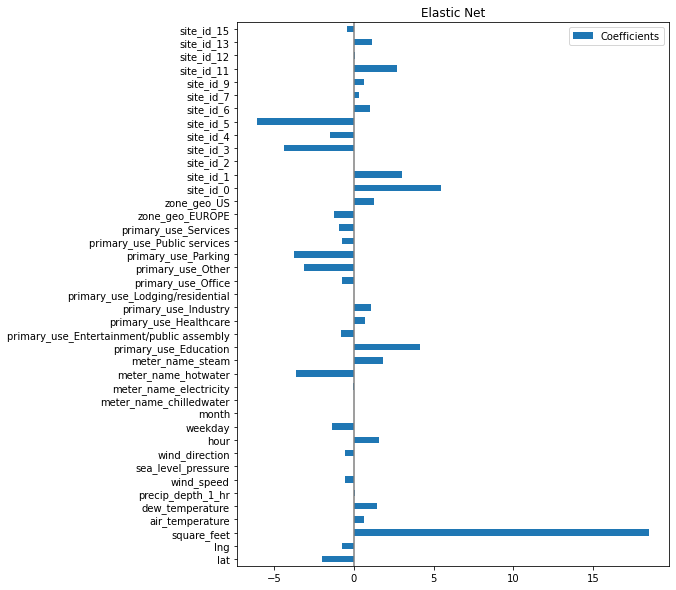

In [22]:
coefs = pd.DataFrame(
   model_en.coef_,
   columns=['Coefficients'], index=train_features.columns
)

coefs.plot(kind='barh', figsize=(10, 10))
plt.title('Elastic Net')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

In [23]:
print_errors(model_en, val_features, val_target)

MAE : 56
MSE : 4851


You can also use the feature importance of your model in order to train a the same model on the main features, which explain the most the target.

# Cross validation

The most common method to find a good model for a given use case usually consists in:
- training various models on a training set
- comparing their performance on a validation set
- finally, check whether the best models generalize properly on new data by comparing their predictions on a test set, which serves as a common benchmark.

However, this may limitate the comparability of models and lead to erroneous conclusions, as the performance of a given algorithm may depend on the training data, and sometimes change even if the training data remains the same (this happens when some model parameters or input are initialized randomly).

In order to mitigate this risk, one might resort to cross-validation:
- the dataset is only divised into two parts: a training and a test set
- the training set is divided into N parts, and we're going to train N distinct models (with identical hyperparameters though)
- each model will be trained on N-1 parts (or folds) of the training set, and its performance will be assessed on the remaining fold
- at the end, we average the performance of the model obtained on the N validation games.

The whole process is illustrated on the following chart:

Illustration of cross validation on 5 folds :

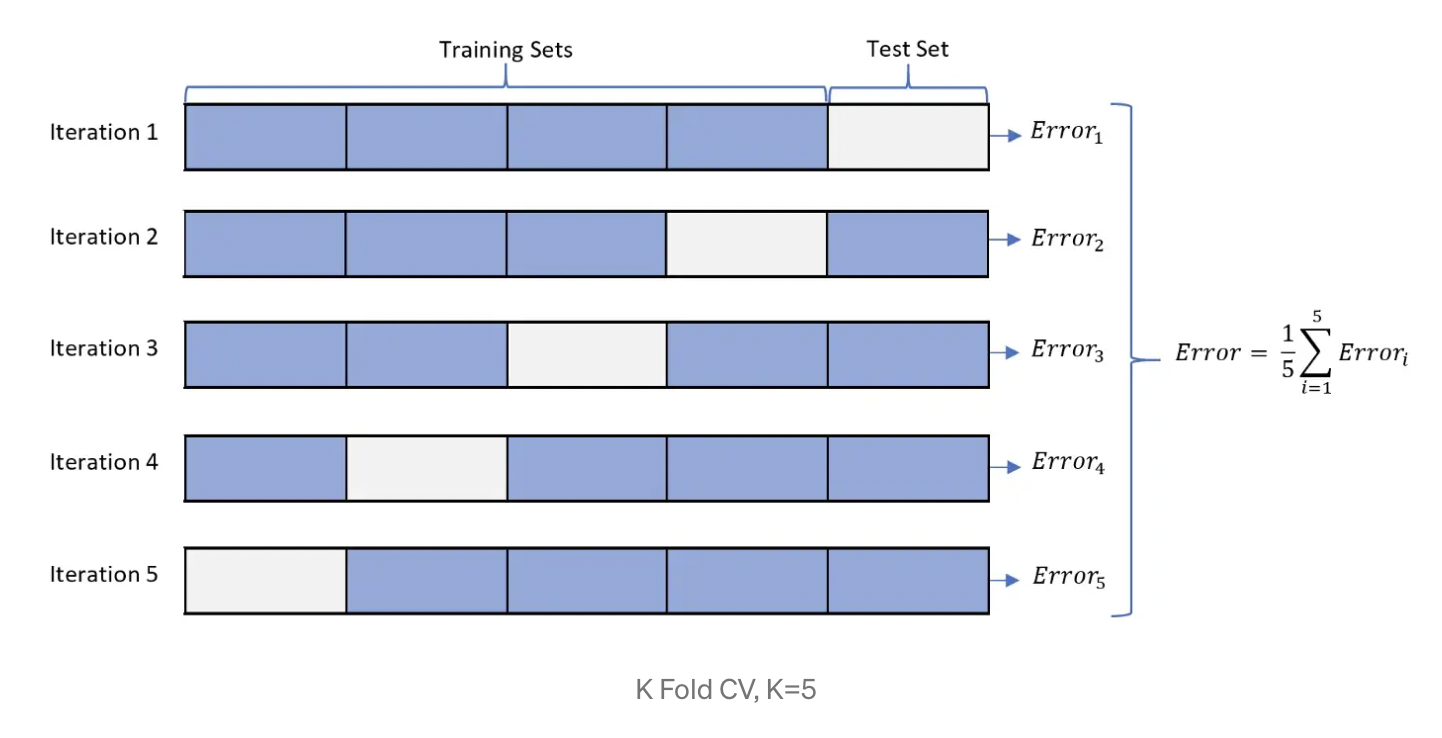

In [5]:
#<img src="../../src/figures/cross_validation.png" width=700 height=400 />
display.Image("../src/figures/cross_validation.png")

The main benefit of using this method is to compare different model types based on average values, instead of a single measure. However, this comes at a computational cost.

A detailed example with code is provided in notebook 3.

# Next steps

In this notebook, we have mainly focused on regularization as a means to prevent overfitting. Please see the other two notebooks to see:
- methods to select features (for instance in order to prevent overfitting)
- good practices to look for optimal hyperparameters

$\textbf{Go further ! }$
- Hastie T., Tibshirani R., Friedman J., « [The elements of Statistical Learning](http://statweb.stanford.edu/~tibs/ElemStatLearn/) - Data Mining, Inference and Prediction », pringer, 2009.